In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from model import TimeTransformer
from data_preprocessing import load_data
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters
INPUT_DIM = 7  # Updated features
EMBED_DIM = 64
NHEAD = 4
NUM_LAYERS = 3
OUTPUT_DIM = 1  # Predict pickup count
SEQ_LEN = 24  # Predict using last 24 timesteps
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 50
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Load data
train_loader, test_loader, scaler = load_data("/scratch/gl2758/PTSA/output/MSG_30min_raw_train.csv", batch_size=BATCH_SIZE, seq_len=SEQ_LEN)

# Model, loss, optimizer
model = TimeTransformer(INPUT_DIM, EMBED_DIM, NHEAD, NUM_LAYERS, OUTPUT_DIM, SEQ_LEN).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.unsqueeze(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss:.4f}")

/ext3/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 6318.4174
Epoch 2/50, Loss: 4411.8274
Epoch 3/50, Loss: 2820.8026
Epoch 4/50, Loss: 2129.9107
Epoch 5/50, Loss: 1978.2910
Epoch 6/50, Loss: 1898.7502
Epoch 7/50, Loss: 1443.7417
Epoch 8/50, Loss: 1328.6065
Epoch 9/50, Loss: 1389.4051
Epoch 10/50, Loss: 1238.6462
Epoch 11/50, Loss: 1136.0441
Epoch 12/50, Loss: 930.9774
Epoch 13/50, Loss: 880.5525
Epoch 14/50, Loss: 841.2603
Epoch 15/50, Loss: 824.0322
Epoch 16/50, Loss: 759.6596
Epoch 17/50, Loss: 730.2668
Epoch 18/50, Loss: 692.1185
Epoch 19/50, Loss: 625.1110
Epoch 20/50, Loss: 581.8157
Epoch 21/50, Loss: 560.1879
Epoch 22/50, Loss: 535.2508
Epoch 23/50, Loss: 516.3275
Epoch 24/50, Loss: 497.0946
Epoch 25/50, Loss: 473.8240
Epoch 26/50, Loss: 461.3913
Epoch 27/50, Loss: 533.7416
Epoch 28/50, Loss: 492.6416
Epoch 29/50, Loss: 425.7210
Epoch 30/50, Loss: 408.2061
Epoch 31/50, Loss: 402.5856
Epoch 32/50, Loss: 400.6589
Epoch 33/50, Loss: 390.0417
Epoch 34/50, Loss: 379.2446
Epoch 35/50, Loss: 365.7127
Epoch 36/50, Loss:

In [4]:
# Evaluate model
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        predictions = model(X_batch).cpu().numpy()
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predictions)

# Metrics
y_true, y_pred = np.array(y_true), np.array(y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Test RMSE: {rmse:.4f}, R^2 Score: {r2:.4f}")


Test RMSE: 16.1132, R^2 Score: 0.8646


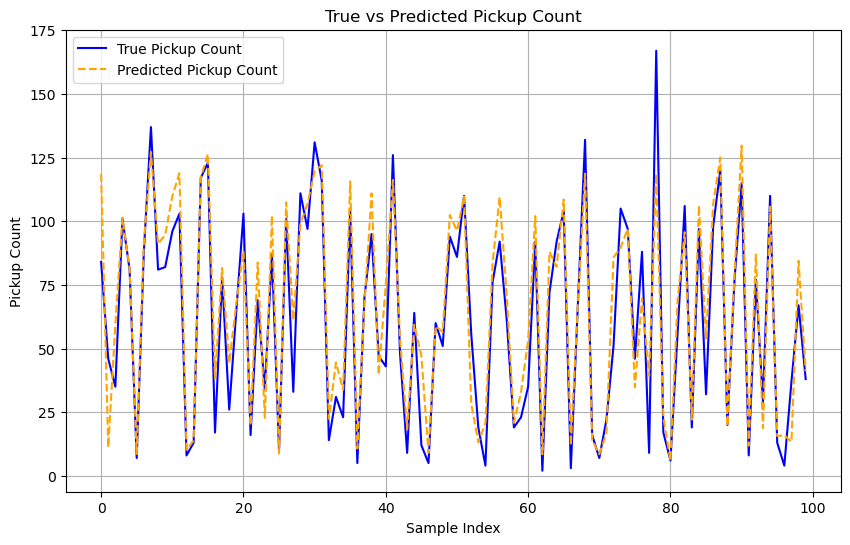

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_true[:100], label="True Pickup Count", color="blue")
plt.plot(y_pred[:100], label="Predicted Pickup Count", color="orange", linestyle="--")
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("True vs Predicted Pickup Count")
plt.legend()
plt.grid()
plt.show()